# Transformer - 기본 과제 (Last word prediction)
```
- IMDb 데이터셋
- Binary Classification Model => Last word prediction Model 변환 작업
```

**기본 과제 코드 자체 분석**   
[![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week2/Transformer-study.ipynb)
<br>
**BERT vs GPT Tokenizer**   
[![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week2/BERT-vs-GPT-Tokenizer.ipynb)
<br>
**Embedding**   
[![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week2/Embedding.ipynb)
<br>
**Positional Encoding**   
[![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week2/Positional-Encoding.ipynb)


In [1]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" 

In [51]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from torch.nn.utils.rnn import pad_sequence

# ds = load_dataset("stanfordnlp/imdb")
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

# Train/Test IMDb 데이터셋 출력 확인
print(train_ds[0]['text'])
print(train_ds[0]['label'])

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

**BERT Tokenizer Fnc**   
- to_tensor 값에 따라 PyTorch Tensor type 혹은 Numpy 배열로 리턴한다
- `collate_fn`에서 `pad_sequence`를 통해 동적 padding 수행하기에 `padding=True` 제외
  - 데이터셋 중 가장 긴 문장길이가 200이라고하면, max_len으로 지정한 400으로 모두 padding 처리하는 것은 비효율
  - 200으로 동적 padding을 수행해줌

In [3]:
def tokenizer_bert(text, max_length, to_tensor=False):

  return tokenizer(text, truncation=True, max_length=max_length, return_tensors= 'pt' if to_tensor else None)

## `collate_fn(batch)`
- PyTorch DataLoader에서 batch 단위로 데이터를 불러옴
- 불러온 각 데이터를 어떻게 하나의 batch로 묶을지 정의하는 함수
``` python
DataLoader(dataset, batch_size=64, collate_fn=collate_fn)
```

**방향성**   
- 보다 명확히 유효 토큰을 필터링하여 리턴한다

**batch**   
- 길이: 64 `batch_size`지정 값
- 각 원소는 dataset[i]
``` python
  {'text': ...., 'label':....} 👉🏻 상단에 print 부분 참조

  # 즉 아래와 같은 형태
  batch = [dict(text='sep1,,', label=0), dict(text='sep2,,', label=1), ...]
```

<br>

**`torch.nn.utils.rnn.pad_sequence`**   
- 여러 길이의 sequence를 하나의 tensor로 묶기위해 padding을 자동으로 추가
- 같은 크기로 맞춰줌
  - Model에 batch로 넣기 위해 꼭 필요함
``` python
    texts = [
      torch.tensor([101, 2009, 2001]),
      torch.tensor([101, 1996]),
      torch.tensor([101, 1996, 2190, 3185])
    ]

    pad_sequence(texts, batch_first=True, padding_value=0)

    👉🏻 tensor([
      [101, 2009, 2001,    0],
      [101, 1996,    0,    0],
      [101, 1996, 2190, 3185]
    ])
```

In [55]:
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []

  # ignore token을 지정
  # ignore_policy를 제외함
  IGNORE_TOKENS = {
      tokenizer.sep_token_id,
      tokenizer.pad_token_id,
      # list comprehension
      *[tokenizer.convert_tokens_to_ids(ignore_policy) for ignore_policy in ['.', ',', '?', '!', ';']]
  }

  for row in batch:

    # input_ids: BERT Tokenization, input_ids 추출
    ids = tokenizer_bert(row['text'], max_len).input_ids

    # 유효 label 찾기: 뒤에서 부터 하나씩 체크
    for i in range(len(ids) - 1, -1, -1):
      token_id = ids[i]
      if token_id not in IGNORE_TOKENS:
        label_id = token_id
        label_pos = i
        break
      # 유효 토큰이 없는 경우 넘어감
      else:
        continue

    # 입력 값에서 label 제외
    # 유효 text만 추출
    ids = ids[:label_pos]
    if len(ids) < 2:
      continue

    texts.append(torch.LongTensor(ids))
    labels.append(label_id)

  # 유효 text가 하나도 없으면 빈 텐서 리턴
  # 빈 텐서를 pad_sequence 처리하면 에러 발생
  if not texts:
    return torch.empty(0), torch.empty(0)

  # policy에 맞는 유효 토큰을 추출한 후
  # Model에 넣기 전 전처리
  # tokenizer에서 진행하지 않은 padding 작업을 수행하여
  # 정사각 tensor로 변환
  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

## Self-attention

In [56]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

### Transformer Layer
- Self-Attention
- Feed Forward Layer

In [57]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

## Positional encoding

$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

In [58]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


### WordPredictor (Transformer Layer + Positional Encoding)
**Binary Classification => Last Word Prediction 변경**   
- output 차원을 1 => vocab_size로 변경
```
👉🏻 예측할 class의 수가 vocab_size 만큼 있기 때문에 변경한다
```
<br>

**Asis**   
- 긍정 or 부정
- 1개의 logit으로 표현 (sigmoid를 통한 확률 추출)
- 총 class: 2개 (0, 1)
``` python
# 이진 분류 0 or 1 class
self.classification = nn.Linear(d_model, 1)
```
<br>

**Tobe**
- BERT vocab 내 모든 단어 중 **가장 가능성이 높은 단어를 예측한다**
- 총 class: `vocab_size`개 (BERT에서는 30,522개)
``` python
self.classification = nn.Linear(d_model, vocab_size)
```   

<br>

**forward**   
`x`: collate_fn에서 pad_sequence 처리되어 동적 padding 처리된 input tensor (text)   
``` python
x = [
  [101, 2023, 2003, 1037, 2742, 102, 0, 0, 0],  # padding 포함된 문장
  [101, 2057, 2293, 2009, 102, 0, 0, 0, 0]
]

# x.shape = (B, S) # B: 배치 크기, S: 최대 시퀀스 길이

# 101 = [CLS]
# 102 = [SEP]
# 0 = [PAD] (tokenizer.pad_token_id)
```
- `mask`
  - Transformer는 Self-Attention을 사용하기에, 모든 토큰이 서로를 참조한다
  - 하지만, `padding`부분은 **무효한 공간이기 때문에** 무시해야한다 => `mask`를 만들어서 padding 부분은 attention score 계산에서 제외시킨다
  ``` python
    # padding된 위치만 골라낸다
    # (B, S)
    mask = (x == tokenizer.pad_token_id)
    
    # (B, S, S) => (B, 1, S)
    # 추후 attention score 계산을 위한 브로드캐스팅
    mask = mask[:, None, :]  # shape: (B, 1, S)
  ```

In [59]:
class WordPredictor(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

    # 이진 분류 => 단어 예측 변경
    # 사용 Model의 vocab에 있는 모든 단어를 참고하여 가장 가능성이 높은 단어를 뽑아내야한다
    self.prediction = nn.Linear(d_model, vocab_size)

  # x: collate_fn에서 return한 text => pad_sequence를 통해 padding이 적용된 상태
  def forward(self, input_ids):
    # 무효한 padding token 부분 제외
    mask = (input_ids == tokenizer.pad_token_id)
    # broadcasting
    mask = mask[:, None, :]
    # (B, S)[1]
    seq_len = input_ids.shape[1]

    # x에 대해 d_model 차원의 벡터로 변환
    x = self.embedding(input_ids)
    # 벡터값이 너무 작아지는 걸 방지하기 위한 scaling
    # BERT/Transformer 논문에서 embedding 벡터의 분산이 1이 되도록 하자는 의도라고 함
    x = x * sqrt(self.d_model)
    # positional encoding을 통한 위치 데이터 삽입
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    # mask 처리되지 않은 실제 입력 시퀀스만 모은 후,
    # 마지막 유효 토큰의 index를 찾아낸다
    # ex> [101, 123, 234, 567, 0, 0] / pad: 2개 / input_length(마지막 유효 토큰 index): 4 - 1 = 3
    # (B,)
    input_length = (input_ids != tokenizer.pad_token_id).sum(dim=1) -1

    # 3차원 텐서에서 마지막 행 마지막 열의 출력값을 꺼낸다
    # 배치 내 각 문장마다 마지막 토큰의 위치를 동적으로 뽑는다
    # torch.arange는 numpy.arrange와 비슷하다
    # (B, D)
    last_output = x[torch.arange(x.size(0)), input_length]

    x = self.prediction(last_output)

    return x


model = WordPredictor(len(tokenizer), 32, 2, 32)

## 학습

### BCEWithLogitsLoss vs CrossEntropyLoss
|항목	|BCEWithLogitsLoss|	CrossEntropyLoss|
|:---|:---|:---|
|목적	|이진 분류|	다중 클래스 분류 (ex. MNIST, 단어 예측 등)
|출력	|(B, 1) 또는 (B,)|	(B, C) (C는 클래스 개수)
|정답	|float/int (0 or 1)|	int (0 ~ C-1 중 하나)
|내부 처리	|sigmoid + binary cross entropy|	softmax + log + negative log likelihood


In [60]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

**Accuracy fnc**   
`평가 모드 적용`
- model.eval()
- with torch.no_grad()



In [61]:
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  model.eval()
  correct = total = 0

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs) # (B, vocab_size) / vocab 내 모든 단어 참고
      preds = torch.argmax(preds, dim=-1) # (B,) / 특정 단어 예측

      correct += (preds == labels).sum().item()
      total += labels.size(0)

  return correct / total

**시각화 함수**

In [65]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["test_acc"], label="Test Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [68]:
n_epochs = 50

# 학습 기록용
history = {
    "train_loss": [],
    "train_acc": [],
    "test_acc": []
}

for epoch in range(n_epochs):
  torch.cuda.empty_cache()

  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    optimizer.zero_grad()

    preds = model(inputs) # (B, vocab_size)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # print(f'실제로 랜덤하게 나오는지 정답 뽑아보기\n{tokenizer.convert_ids_to_tokens(labels[:10].tolist())}')

  print(f"Epoch {epoch + 1:3d} | Train Loss: {total_loss}")

  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)

  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

  # 기록 저장
  history["train_loss"].append(total_loss)
  history["train_acc"].append(train_acc)
  history["test_acc"].append(test_acc)

Epoch   1 | Train Loss: 75.73436880111694
=========> Train acc: 0.149 | Test acc: 0.011
Epoch   2 | Train Loss: 74.5088255405426
=========> Train acc: 0.146 | Test acc: 0.017
Epoch   3 | Train Loss: 73.45684766769409
=========> Train acc: 0.146 | Test acc: 0.021
Epoch   4 | Train Loss: 73.25341296195984
=========> Train acc: 0.152 | Test acc: 0.018
Epoch   5 | Train Loss: 74.33871459960938
=========> Train acc: 0.161 | Test acc: 0.014
Epoch   6 | Train Loss: 72.24047422409058
=========> Train acc: 0.179 | Test acc: 0.016
Epoch   7 | Train Loss: 70.78261232376099
=========> Train acc: 0.165 | Test acc: 0.019
Epoch   8 | Train Loss: 70.05832099914551
=========> Train acc: 0.175 | Test acc: 0.019
Epoch   9 | Train Loss: 69.59103059768677
=========> Train acc: 0.175 | Test acc: 0.020
Epoch  10 | Train Loss: 69.60202312469482
=========> Train acc: 0.168 | Test acc: 0.013
Epoch  11 | Train Loss: 69.9627616405487
=========> Train acc: 0.154 | Test acc: 0.014
Epoch  12 | Train Loss: 67.4922931

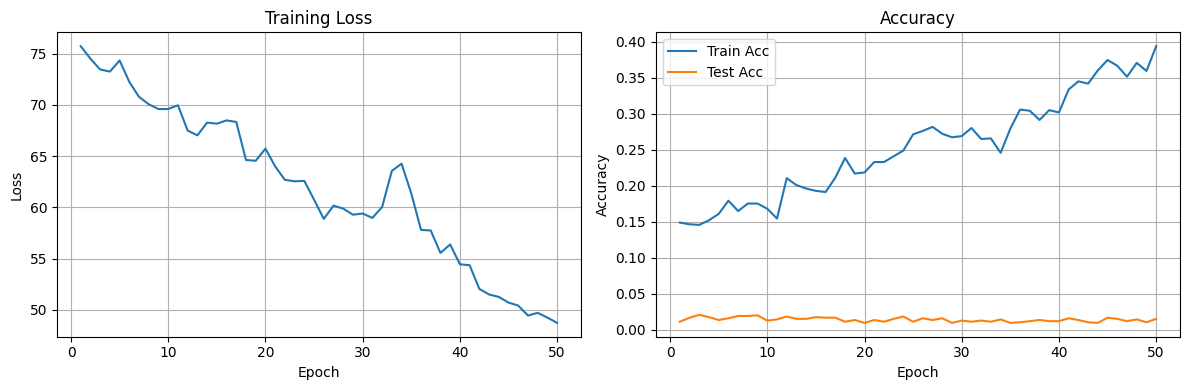

In [69]:
plot_training(history)

### Loss는 줄고, Train Acc는 증가 / Test Acc는 감소
**나의 생각**   
- 30522개의 방대한 vocab 중 1개를 맞춰야 하는 task라 평균 확률로 회귀하는것인가..? 🤔

<br>

**GPT의 의견**   
✅ 1. 정답 클래스가 30,000개가 넘는 다중 분류 문제
- 우리가 풀고 있는 건 **단어 예측**, 즉 vocab_size = 30522개의 클래스 중 정답 1개만 맞춰야 함

- 이건 사실상 "초고난이도 단어 맞추기 퀴즈" 같은 느낌

✅ 2. 정답 분포가 매우 불균형
- 예측해야 하는 마지막 단어는 실제로 다양하지만,

- 모델 입장에선 확률을 30,000개로 나눠야 하다 보니, 결국 "**자주 등장하는 단어**"에 확률을 몰기 시작함

- 그래서 loss는 줄지만 accuracy는 떨어지거나 요동치는 현상이 나와

<br>

**📈 지금 상태에서 loss는 왜 줄어드는데 accuracy는 안 좋을까?**   

|요소|	이유|
|:---|:---|
|Loss|	전체 분포(softmax output)를 기준으로 계산 → "조금이라도 정답에 가까우면" 낮아짐|
|Accuracy|	argmax한 결과가 정답과 완전히 일치해야만 1점 → 작은 차이도 틀린 걸로 취급|


👉🏻 **즉, loss는 모델이 정답 근처로 확률을 몰고 있으면 점점 줄 수 있지만,
accuracy는 맞거나 틀리거나 둘 중 하나라서 더 민감하게 출렁이는 것**

<br>


**🎯 이럴 때의 모델 학습 상태 느낌**   
>“얘가 정답 근처 단어는 점점 더 잘 고르는데, 아직 정확히 맞히는 건 못하고 있어.”   
<br>
지금 네 모델은 "30522개 중 하나를 맞추는 초고난이도 퀴즈"에서, 점점 정답 근처로 접근 중이지만 아직 정확히 못 맞추고 있어서 accuracy가 출렁이는 상태야.

<br>

**🔧 어떻게 개선할 수 있을까?**   

|방법|	설명|
|:---|:---|
|`d_model`, `n_layers` 키우기|	vocab 표현력을 높여서 정확히 "어떤 단어인지" 구별할 수 있게 함|
|더 많은 epoch|	loss는 천천히 내려가지만, 정확도는 어느 순간 갑자기 튀어오를 수 있음|
|`top-k accuracy` 측정|	예: top-3 안에 정답 있으면 OK로 → 지금 모델이 "거의 맞췄는지" 확인 가능|
|subword 수준 평가|	`[mask]` 예측처럼 여러 토큰으로 나뉜 단어 단위로 평가하면 정확도 높일 수 있음|
